    
<img align="center" src="Cancer_Detection.jpeg" style="width:100;height:80px;">
    
# Comparative Analysis of Classification Algorithms for Breast Cancer Detection
    
## Objective

The main purpose of this project is to construct a prediction model for breast cancer using several classification algorithms and then make a comparative analysis of performance and accuracy. Models will be deployed using (4) algorithms:

* Logistic Regression
* Support Vector Machine (SVM)
* K-Nearest neighbors
* Decision trees



## Table of contents
1. [About the dataset](#about_dataset)
2. [Data pre-processing and selection](#preprocessing)
3. [Modeling](#modeling)
    * [Logistic Regression](#lr)
    * [Support Vector Machine (SVM)](#svm)
    * [Decision tree](#tree)
    * [K-Nearest neighbors(K-NN)](#knn)
5. [Conclusions](#conclusions)


<a class="anchor" id="about_dataset"></a>
<h2>1. About the dataset</h2>

The project is based on a dataset that is publicly available from the UCI Machine Learning Repository:

https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original

Dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>

Let's first import required libraries:


In [33]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, jaccard_score, classification_report
from sklearn import svm


### 2. Data preprocessing and selection

In [34]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

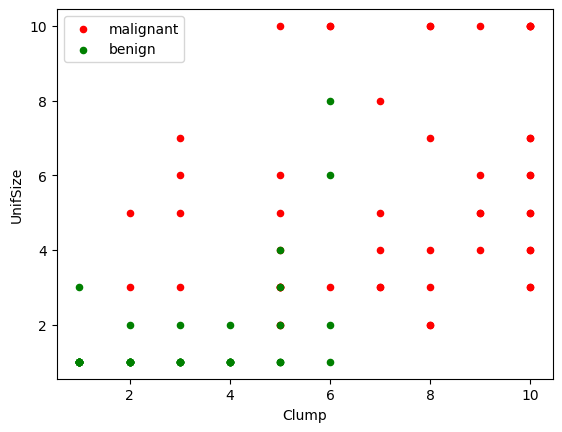

In [35]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Red', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Green', label='benign', ax=ax);
plt.show()

In [36]:
cell_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


<a class="anchor" id="preprocessing"></a>
<h2>2. Data pre-processing and selection</h2>


The __BareNuc__ column includes some values that are not numerical. 
We can drop those rows:


In [37]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

Feature vectors (X) and label vectors (y) are retrieved out of the dataframe and converted to numpy arrays for further manipulation by the algorithms

Feature and label vectors extracted from the Datatrame:

In [38]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
print(X[0:5])
y = np.asarray(cell_df['Class'])
print(y [0:5])

[[ 5  1  1  1  2  1  3  1  1]
 [ 5  4  4  5  7 10  3  2  1]
 [ 3  1  1  1  2  2  3  1  1]
 [ 6  8  8  1  3  4  3  7  1]
 [ 4  1  1  3  2  1  3  1  1]]
[2 2 2 2 2]


#### Train/Test dataset


We split our dataset into train and test set:


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<a class="anchor" id="modeling"></a>
<h2>3. Modeling</h2>
<a class="anchor" id="lr"></a>
<h3 id="Logistic Regression">3.1. Logistic Regression</h3>

We build the first model using __LogisticRegression__ from the Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem of machine learning models.
__C__ parameter indicates __inverse of regularization strength__ which must be a positive float. Smaller values specify stronger regularization. 
We use the GridSearchCV function to test several combinations of parameters C so that the best set of paremeters is chosen


In [40]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [41]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.9689562289562289


In [42]:
yhat = logreg_cv.predict(X_test)
yhat

array([2, 4, 2, 4, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4, 2,
       4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4,
       4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 4, 4, 2, 2, 4,
       4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 4, 4, 2, 2, 2, 2, 4, 4, 2, 4,
       2, 2, 4, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 2, 4, 2, 2, 4,
       2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 4, 2, 2, 4, 2, 4, 2,
       2, 2, 2, 2, 4])

In [43]:
jaccard_score(y_test, yhat, pos_label=4)

0.9215686274509803

In [44]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137



<h3 id="evaluation">Evaluation</h3>


#### jaccard index
Let's try the jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by the size of the union of the two label sets. If the entire set of predicted labels for a sample strictly matches with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.



In [46]:
jaccard_score(y_test, yhat, pos_label=4)

0.9215686274509803

#### confusion matrix
Another way of looking at the accuracy of the classifier is to look at __confusion matrix__.


In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[2,4]))

[[86  4]
 [ 0 47]]


Confusion matrix, without normalization
[[86  4]
 [ 0 47]]


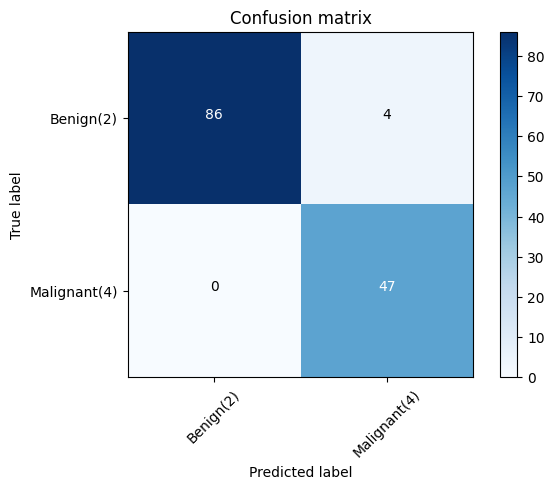

In [48]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

As we can see, the amount of false positives and false negatives is very low. The predicted classes match most of the reality. Only 4 cells were predicted malignant but they were actually benignant. The rest 133 cells (86 + 47) were predicted correctly.

In [49]:
print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137



Based on the count of each section, we can calculate precision and recall of each label:


- __Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

- __Recall__ is the true positive rate. It is defined as: Recall =  TP / (TP + FN)

    
So, we can calculate the precision and recall of each class.

__F1 score:__
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label. 

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.


Finally, we can tell the average accuracy for this classifier is the average of the F1-score for both labels, which is 0.975 in our case.


<a class="anchor" id="svm"></a>
<h3><id="modeling"> 3.2. Support Vector Machine (SVM)</h3>

Now we use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Again, we use the GridSearchCV function to determine the best combination of hyperparemeters

In [50]:
from sklearn.svm import SVC

parameters = {'kernel':('linear', 'rbf','poly', 'sigmoid'),
              'C': np.logspace(-3, 3, 10),
              'gamma':np.logspace(-3, 3, 5)}
svm_cv = SVC()

svm_cv = GridSearchCV(svm_cv, parameters, cv=10)
svm_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00e-03, 4.64e-03, 2.15e-02, 1.00e-01, 4.64e-01, 2.15e+00,
       1.00e+01, 4.64e+01, 2.15e+02, 1.00e+03]),
                         'gamma': array([1.00e-03, 3.16e-02, 1.00e+00, 3.16e+01, 1.00e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [51]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}
accuracy : 0.9726262626262626


After being fitted, the model can then be used to predict new values:

In [52]:
yhat = svm_cv.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


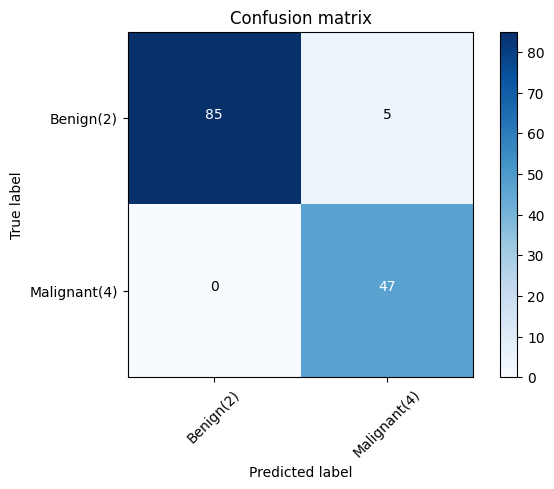

In [53]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

Exactly the same as the confusion matrix with Logistic Regression. Average F1 score for both labels is 96%

<a class="anchor" id="tree"></a>
<h3><id="modeling">3.3. Decision Tree</h3>

Now, a decision tree will be trained to predict whether a cell is benign or malignant based on its features. We will first create an instance of the DecisionTreeClassifier

In [54]:
cellTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [55]:
cellTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

Now, let's make some predictions

In [56]:
predTree = cellTree.predict(X_test)

Now, we can compare predictions vs actual labels for first 10 entries

In [57]:
print (predTree [0:10])
print (y_test [0:10])


[2 4 2 4 2 2 2 2 4 2]
[2 4 2 4 2 2 2 2 4 2]


Let's check the accuracy of the model

In [58]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.9708029197080292


              precision    recall  f1-score   support

           2       0.98      0.98      0.98        90
           4       0.96      0.96      0.96        47

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137

Confusion matrix, without normalization
[[88  2]
 [ 2 45]]


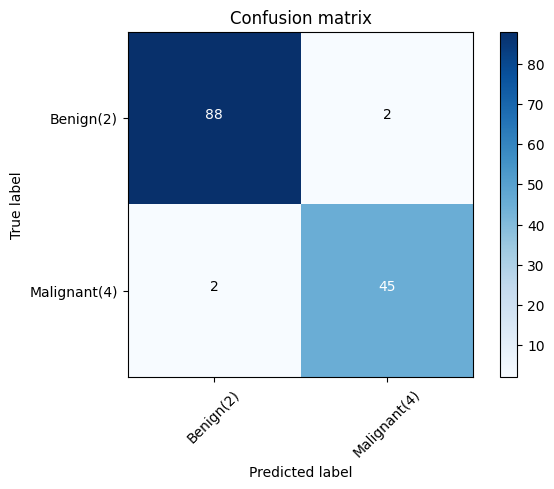

In [59]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predTree, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, predTree))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

Average F1 score for both labels is 97%

<a class="anchor" id="knn"></a>
<h3><id="modeling">3.4. K Nearest Neighbors </h3>

Now we create a k nearest neighbors object and then create a GridSearchCV object knn_cell with cv = 10. Fit the object to find the best parameters from the dictionary parameters.

In [60]:
N = KNeighborsClassifier()
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

knn_cv = GridSearchCV(N, parameters, cv=10)
knn_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [61]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 2}
accuracy : 0.9744444444444443


Now we plot the confussion matrix

              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137

Confusion matrix, without normalization
[[86  4]
 [ 0 47]]


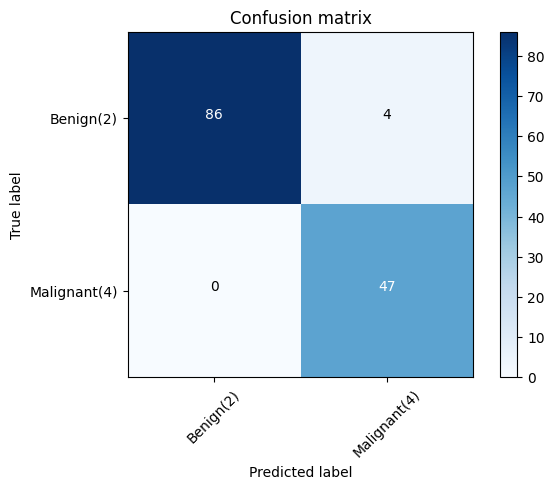

In [62]:
# Compute confusion matrix
yhat = knn_cv.predict(X_test)
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

Average F1 score for both labels is 97%

<a class="anchor" id="conclusions"></a>
# 4. Conclusions 

A comparative analysis of four (4) classification algorithms has been carried out in order to predict with high accuracy breast cancer based on cell characteristics. The project uses a dataset publicly available from the UCI Machine Learning Repository as described in section 1. Hyperparameter tuning was performed in all the algorithms (using GridSearchCV from SKlearn) to find the combination that rendered best performance. The following table summarizes the algorithms used, accuracy scores achieved and best combination of parameters obtained through the hyperparemeter tuning.



|Classification Algorithm|F1 score|Parameters|
|--- |--- |--- |
|Logistic Regression|97.5%| 'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'|
|SVM (Support Vector Machine)|96%| 'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'|
|K-Nearest neighbors | 97%| criterion='entropy', max_depth=4|
|Decision trees|97%| 'algorithm': 'auto', 'n_neighbors': 5, 'p': 2|

<br>
It can be seen that the four algortihms produce high accuracy, particularly logistic regression, K-NN and Decision trees with scores above 97%
